# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Reusable Function

In [2]:
def report_results(y_test, y_pred, model_name):
  # Accuracy Score
  accuracy = accuracy_score(y_test, y_pred)
  print(f"{model_name} Accuracy Score: {accuracy}")

  # Precision, Recall, F1 Score
  print(classification_report(y_test, y_pred))

  # Confusion Matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f"{model_name} Confusion Matrix")
  plt.show()

# Load Dataset


In [3]:
df = pd.read_csv('Datasets/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# Preprocessing

In [7]:
X = df.drop(columns = ['Outcome', 'Pregnancies'])
y = df['Outcome']

# Columns that need scaling
numerical_features = X.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler())
        ]), numerical_features)
    ]
)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training

In [8]:
# Pipeline with preprocessor and LogisticRegression model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('classifier', LogisticRegression())])

# Predictions

In [9]:
# Predict Outcomes
y_pred = model.predict(X_test)

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_results.head()

,Actual,Predicted
668,0,0
324,0,0
624,0,0
690,0,0
473,0,0


# Model Evaluation

Naive Model Accuracy Score: 0.7662337662337663
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        99
           1       0.68      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.77       154



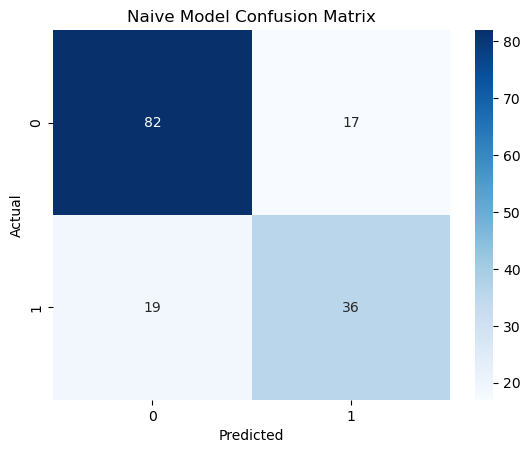

In [10]:
# predefined function
report_results(y_test, y_pred, 'Naive Model')

# Improving Logistic Regression

The following methods could be used to tune Logistic Regression for better performance
1.   **Regularization:** Lasso (L1) and Ridge (L2)
2.   **Handling Class Imbalance**
3.   **Feature Engineering:** Feature Selection
4.   **Polynomial Regression:** Adding Polynomial Features





#### L1 (Lasso) Regression
Shrinks some feature weights to **zero**, performing **feature selection**



In [11]:
lasso = LogisticRegressionCV(Cs=10, penalty='l1', solver='liblinear', cv=5, random_state=42)

lasso_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lasso)
])

lasso_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegressionCV(cv=5, penalty='l1', random_state=42,
                                      solver='liblinear'))])

In [12]:
lasso_y_pred = lasso_model.predict(X_test)

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': lasso_y_pred})
df_results.head()

,Actual,Predicted
668,0,0
324,0,0
624,0,0
690,0,0
473,0,0


#### L2 (Ridge) Regression
Penalizes large weights but keeps all features

In [13]:
ridge = LogisticRegressionCV(Cs=10, penalty='l2', solver='lbfgs', cv=5, random_state=42)

ridge_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ridge)
])

ridge_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('classifier', LogisticRegressionCV(cv=5, random_state=42))])

In [14]:
ridge_y_pred = ridge_model.predict(X_test)

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': ridge_y_pred})
df_results.head()

,Actual,Predicted
668,0,0
324,0,0
624,0,0
690,0,0
473,0,0


#### Handling Class Imbalance

In [15]:
balanced_model = LogisticRegression(class_weight='balanced', solver='lbfgs', random_state=42)

balanced_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', balanced_model)
])

balanced_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=42))])

In [16]:
balanced_y_pred = ridge_model.predict(X_test)

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': balanced_y_pred})
df_results.head()

,Actual,Predicted
668,0,0
324,0,0
624,0,0
690,0,0
473,0,0


#### Feature Selection

In [17]:
from sklearn.feature_selection import SelectFromModel

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectFromModel(Lasso(alpha=0.1), threshold="mean"))
        ]), numerical_features)
    ]
)

selector_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

selector_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('feature_selection',
                                                                   SelectFromModel(estimator=Lasso(alpha=0.1),
                                                                                   threshold='mean'))]),
                                                  Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('classifier', LogisticRegression())])

In [18]:
selector_y_pred = selector_model.predict(X_test)

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': selector_y_pred})
df_results.head()

,Actual,Predicted
668,0,0
324,0,0
624,0,0
690,0,0
473,0,0


#### Polynomial Regression

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False))
        ]), numerical_features)
    ]
)

poly_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

poly_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
       'DiabetesPedigreeFunction', 'Age'],
      dtype='object'))])),
                ('classifier', LogisticRegression())])

In [20]:
poly_y_pred = poly_model.predict(X_test)

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': poly_y_pred})
df_results.head()

,Actual,Predicted
668,0,0
324,0,0
624,0,0
690,0,0
473,0,1


# Imporved Models Evaluation

Lasso Model Accuracy Score: 0.7662337662337663
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        99
           1       0.68      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.77       154



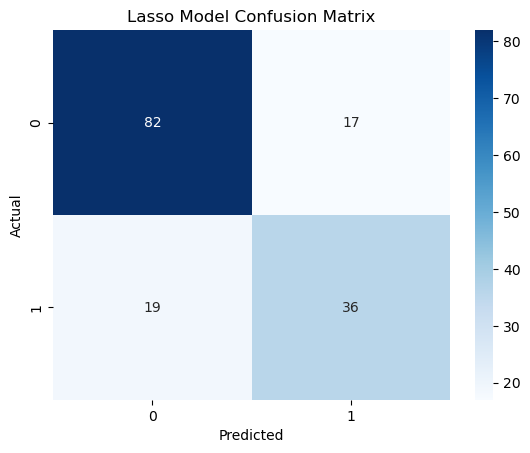

Ridge Model Accuracy Score: 0.7662337662337663
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        99
           1       0.68      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.77       154



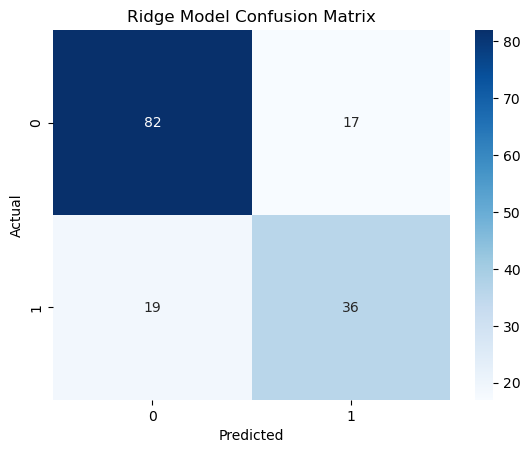

Balanced Model Accuracy Score: 0.7662337662337663
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        99
           1       0.68      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.77       154



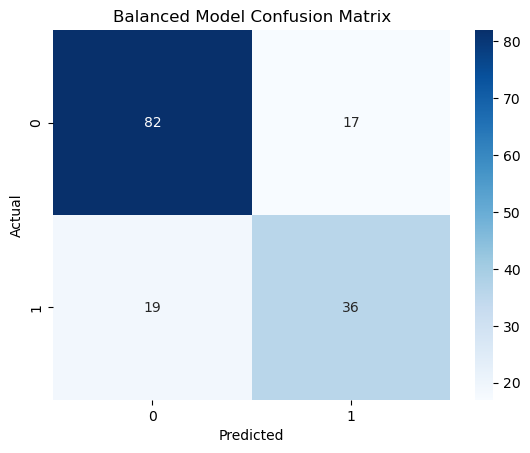

Feature Selection Model Accuracy Score: 0.7662337662337663
              precision    recall  f1-score   support

           0       0.80      0.85      0.82        99
           1       0.69      0.62      0.65        55

    accuracy                           0.77       154
   macro avg       0.75      0.73      0.74       154
weighted avg       0.76      0.77      0.76       154



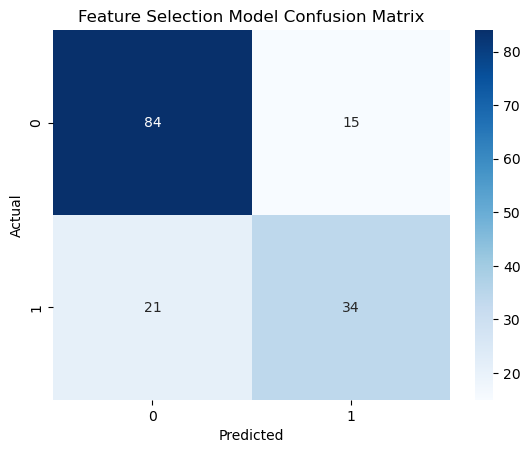

Polynomial Model Accuracy Score: 0.7467532467532467
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        99
           1       0.66      0.60      0.63        55

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.74      0.75      0.74       154



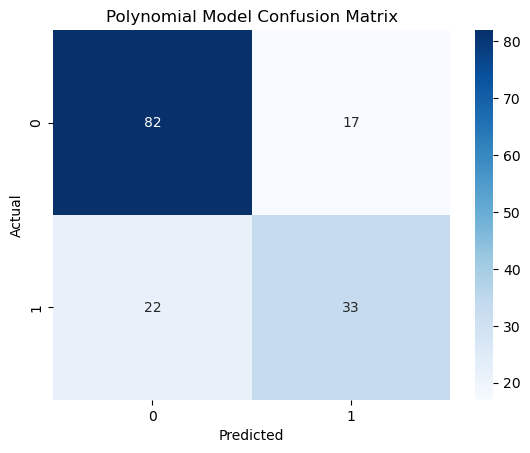

In [21]:
# Lasso Model Results
report_results(y_test, lasso_y_pred, "Lasso Model")
# Ridge Model Results
report_results(y_test, ridge_y_pred, "Ridge Model")
# Balanced Model Results
report_results(y_test, balanced_y_pred, "Balanced Model")
# Feature Selection Model Results
report_results(y_test, selector_y_pred, "Feature Selection Model")
# Polynomial Model Results
report_results(y_test, poly_y_pred, "Polynomial Model")